In [7]:
import sasktran as sk
import numpy as np

TANALTS_KM = [10, 30, 60]
WAVELENGTHS = [280, 310, 330, 600]



def run_for_spacing(grid_spacing):
    alts = np.arange(0, 100001, grid_spacing)


    air_dens = sk.MSIS90().get_parameter('SKCLIMATOLOGY_AIRNUMBERDENSITY_CM3', 0, 0, alts, 54372)
    o3_dens = sk.Labow().get_parameter('SKCLIMATOLOGY_O3_CM3', 0, 0, alts, 54372)
    temp = sk.MSIS90().get_parameter('SKCLIMATOLOGY_TEMPERATURE_K', 0, 0, alts, 54372)
    pres = sk.MSIS90().get_parameter('SKCLIMATOLOGY_PRESSURE_PA', 0, 0, alts, 54372)

    air = sk.Species(sk.Rayleigh(), sk.ClimatologyUserDefined(alts, {'air': air_dens}))
    o3 = sk.Species(sk.O3DBM(), sk.ClimatologyUserDefined(alts, {'o3': o3_dens}))
    background = sk.ClimatologyUserDefined(alts, {'SKCLIMATOLOGY_TEMPERATURE_K': temp,
                                                  'SKCLIMATOLOGY_PRESSURE_PA': pres})

    atmo = sk.Atmosphere()

    atmo['air'] = air
    atmo['o3'] = o3
    atmo.atmospheric_state = background

    geo = sk.VerticalImage()
    geo.from_sza_saa(60, 60, 0, 0, TANALTS_KM, 54372, 0)

    engine = sk.EngineCO(geometry=geo, atmosphere=atmo, wavelengths=WAVELENGTHS,
                         options={'msmode': 0,
                                  'altitudegrid': alts})

    return engine.calculate_radiance('xarray')

In [9]:
import matplotlib.pyplot as plt

true = run_for_spacing(10)

spacings = [50, 100, 200, 250, 500, 1000]
e = np.zeros((len(TANALTS_KM), len(WAVELENGTHS), len(spacings)))

for idz, spacing in enumerate(spacings):
    result = run_for_spacing(spacing)

    p_diff = ((result['radiance'] - true['radiance']) / true['radiance']) * 100


    for idx in range(len(TANALTS_KM)):
        for idy in range(len(WAVELENGTHS)):
            e[idx, idy, idz] = float(p_diff.isel(los=idx, wavelength=idy))

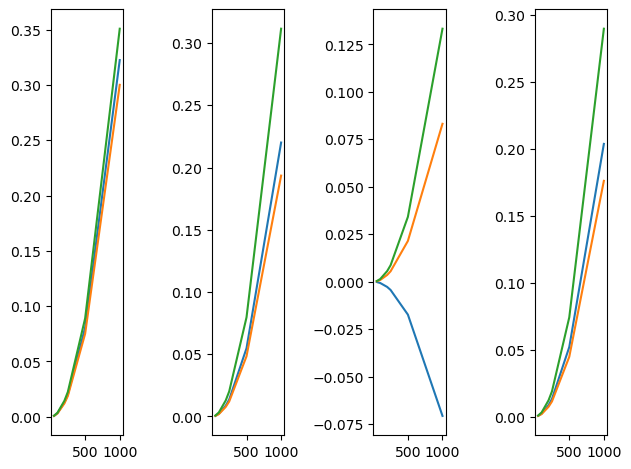

In [12]:
for idx in range(len(TANALTS_KM)):
    for idy in range(len(WAVELENGTHS)):
        plt.subplot(1, len(WAVELENGTHS), idy+1)
        plt.plot(spacings, e[idx, idy, :])

plt.tight_layout()